**Baran CELIK**  
ESPCI Paris – PSL  
Stage de recherche au LPSM

# Résolution numérique d’un problème de switching optimal par apprentissage profond — Cas en dimension 1

Ce notebook présente une partie du travail réalisé dans le cadre d’un stage de recherche au **LPSM (Laboratoire de Probabilités, Statistique et Modélisation)**, en tant qu’étudiant de 3ᵉ année à l’**ESPCI Paris - PSL**.

L’objectif est d’approximer numériquement la solution d’un problème de **contrôle optimal stochastique avec switching à horizon fini**, en combinant :
- une discrétisation du système dynamique via le schéma d’Euler–Maruyama ;
- une résolution backward de l’équation de Bellman discrète ;
- et deux réseaux de neurones : un pour approximer les espérances conditionnelles, un autre pour la politique optimale.

Ce notebook se concentre sur plusieurs **exemples numériques en dimension 1**, incluant un cas simple à solution explicite et un cas non linéaire sans solution connue, comparés à une méthode par différences finies.

*L’analyse des résultats, les choix de modélisation et les justifications mathématiques sont détaillés dans le rapport de stage associé à ce notebook.*

*Un second notebook est consacré à l’extension de la méthode au cas bidimensionnel.*


In [ ]:
import gc
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_sched
from torch.utils.data import DataLoader, TensorDataset
from scipy.sparse import diags
from scipy.sparse import eye
from scipy.sparse.linalg import spsolve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Fonctions d’évaluation de la fonction valeur estimée

Les fonctions `compute_value` et `compute_value2` permettent d’évaluer la fonction valeur initiale $v_0(x, i)$ obtenue par les réseaux de neurones.

- `compute_value` (politique déterministe) : applique la politique optimale apprise sous forme de logits (`PolicyNetwork`) pour choisir l’action optimale, puis calcule la valeur immédiate + future – coût de switching.
- `compute_value2` (politique stochastique) : échantillonne plusieurs actions selon une politique softmax (`PolicyNetwork2`), et renvoie la moyenne des valeurs estimées.

Ces fonctions servent à tracer les fonctions valeur et les politiques apprises dans les exemples numériques.

In [ ]:
@torch.no_grad()
def compute_value(phi, policy_net, x, prev_regime=0):
    logits = policy_net(x)
    best_action = torch.argmax(logits, dim=1, keepdim=True).float()  # (batch, 1)

    immediate = running_payoff(x, best_action) * h
    switch_cost = c * (best_action != prev_regime)
    fut = phi(x, best_action)

    return immediate + fut - switch_cost

@torch.no_grad()
def compute_value2(phi, policy_net, x, prev_regime=0, n_samples=20):
    probs = policy_net(x)  # Déjà des probabilités grâce au softmax
    total_value = 0

    for _ in range(n_samples):
        actions = torch.multinomial(probs, num_samples=1).float()  # (batch, 1)

        immediate = running_payoff(x, actions) * h
        switch_cost = c * (actions != prev_regime)
        fut = phi(x, actions)

        total_value += immediate + fut - switch_cost

    return total_value / n_samples

### Génération des données d’entraînement

La fonction `generate_training_data()` construit un ensemble de données pour entraîner les réseaux à chaque pas de temps $k$.

Pour chaque état simulé $x \in [-5, 5]$, et pour chaque action possible :
- on évalue la récompense immédiate ;
- puis on simule $L$ trajectoires browniennes pour estimer la continuation $v_{k+1}$ ;
- enfin, on retourne un triplet $(x, a, y)$, où $y$ est une estimation Monte Carlo du gain total futur.

Ces triplets servent ensuite à entraîner les réseaux $\phi_k$ (régression) et $\pi_k$ (classification ou softmax) dans la boucle backward.


In [ ]:
# Génération des données d'entraînement
@torch.no_grad()
def generate_training_data(k, M, L, value_fn=None, show_target=False):
    x_cpu = 10 * torch.rand(M, 1) - 5

    out = []
    for act in A:
        a_cpu = torch.full((M, 1), act)
        acc = torch.zeros(M, 1)
        acc += running_payoff(x_cpu, a_cpu) * h

        for _ in range(L):
            x_next = brownian_step(x_cpu, a_cpu, h)
            if k == N - 1:
                v = terminal_payoff(x_next)
            else:
                parts = []
                for s in range(0, M, CHUNK_GPU):
                    xi = x_next[s : s + CHUNK_GPU].to(device)
                    v0 = value_fn(xi, torch.zeros_like(xi))
                    v1 = value_fn(xi, torch.ones_like(xi))
                    parts.append(torch.max(v0, v1).cpu())
                v = torch.cat(parts, dim=0)
            acc += v
        target = acc / L

        for i in range(M):
            out.append((x_cpu[i:i+1], a_cpu[i:i+1], target[i:i+1]))

    return out

### Réseaux de neurones utilisés dans l’algorithme

Trois architectures de réseaux sont utilisées pour approximer les composantes clés de l’équation de Bellman :

- **`ExpectationNetwork`** : approxime l’espérance conditionnelle $
  \phi(x, a) \approx \mathbb{E}[v_{k+1}(X_{k+1}, a) \mid X_k = x]$,
  représentant le gain attendu si l’on choisit l’action $a$ à partir de l’état $x$. Ce réseau est entraîné par régression sur des cibles Monte Carlo.

- **`PolicyNetwork`** : approxime la politique optimale sous forme de logits pour une classification. Il apprend à choisir l’action optimale $a^*(x)$ en maximisant
  $f(x,a)h - c\,\mathbf{1}_{a \ne i} + \phi(x,a)$.

- **`PolicyNetwork2`** : approxime une politique **stochastique** via une couche softmax. Il retourne une distribution de probabilité $\pi(a|x)$ sur les actions, et est entraîné en maximisant l’espérance pondérée du gain futur.

Ces réseaux sont entraînés successivement à chaque pas de temps, dans une procédure de backward induction.

In [ ]:
class ExpectationNetwork(nn.Module):
    def __init__(self, state_dim: int = 1):
        super().__init__()
        input_dim = state_dim + 1
        hidden_dim = 64

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),

            nn.Linear(hidden_dim, 1)
        )


    def forward(self, x: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, action], dim=1)
        return self.network(inputs)



class PolicyNetwork(nn.Module):
    def __init__(self, state_dim=1, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),

            nn.Linear(hidden_dim, 2)  # logits pour a=0 et a=1
        )

    def forward(self, x):
        return self.model(x)  # (batch_size, 2)

class PolicyNetwork2(nn.Module):
    def __init__(self, state_dim: int = 1):
        super().__init__()
        hidden_dim = 64
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

### Entraînement des réseaux de neurones

Cette section contient les fonctions d’apprentissage des trois réseaux utilisés dans l’algorithme backward :

- `train_expectation()` : entraîne le réseau $\phi_\theta$ par régression quadratique sur les cibles Monte Carlo, pour approximer l’espérance conditionnelle.
- `train_policy_classifier()` : entraîne une politique déterministe (logits) via une classification supervisée, avec entropie croisée comme perte.
- `train_policy_stochastic()` : entraîne une politique stochastique (softmax) en maximisant l’espérance du gain pondéré par les probabilités d’action.

Ces fonctions sont appelées à chaque pas de temps $k$ par la fonction centrale `solve_neural_networks()`, qui réalise l’induction backward complète.


In [ ]:
# Fonctions d'entraînement
def train_expectation(phi, data, epochs):
    opt = optim.Adam(phi.parameters(), lr=alpha_phi, weight_decay=5e-5)
    scheduler = lr_sched.CosineAnnealingLR(opt, T_max=epochs)
    criterion = nn.MSELoss()
    x, a, y = map(torch.vstack, zip(*data))
    loader = DataLoader(
        TensorDataset(x, a, y),
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=(device.type == "cuda"),
    )
    losses = []
    for e in range(epochs):
        tot = 0.0
        for xb, ab, yb in loader:
            xb, ab, yb = xb.to(device), ab.to(device), yb.to(device)
            loss = criterion(phi(xb, ab), yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
        scheduler.step()
        tot += loss.item()
        losses.append(tot / len(loader))
        if e % 50 == 0 or e == epochs - 1:
            print(f"    Epoch {e}, Φ-loss={losses[-1]:.4e}, lr={opt.param_groups[0]['lr']:.2e}")
    return losses



def train_policy_classifier(policy_net, phi, x_states, epochs, prev_regime=0):
    opt = optim.Adam(policy_net.parameters(), lr=alpha_p, weight_decay=5e-5)
    scheduler = lr_sched.CosineAnnealingLR(opt, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    losses = []

    for e in range(epochs):
        with torch.no_grad():
            target_values = []
            for act in A:
                a_t = torch.full_like(x_states, act)
                fut = phi(x_states, a_t)
                imm = running_payoff(x_states, a_t) * h
                switch = c * (a_t != prev_regime)
                total = (imm - switch + fut).squeeze()
                target_values.append(total)

            target_values = torch.stack(target_values, dim=1)
            optimal_actions = torch.argmax(target_values, dim=1)

        logits = policy_net(x_states)
        loss = criterion(logits, optimal_actions)

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()

        losses.append(loss.item())
        if e % 50 == 0 or e == epochs - 1:
            acc = (logits.argmax(dim=1) == optimal_actions).float().mean().item()
            print(f"    Epoch {e}, π-classif-loss={loss.item():.4e}, acc={acc:.3f}, lr={opt.param_groups[0]['lr']:.2e}")

    return losses

def train_policy_stochastic(policy_net, phi, x_states, epochs, prev_regime=0):
    opt = torch.optim.Adam(policy_net.parameters(), lr=alpha_p, weight_decay=5e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    losses = []

    for e in range(epochs):
        policy_net.train()

        probas = policy_net(x_states)

        with torch.no_grad():
            target_values = []
            for act in A:
                a_t = torch.full_like(x_states, act)
                fut = phi(x_states, a_t)
                imm = running_payoff(x_states, a_t) * h
                switch = c * (a_t != prev_regime)
                total = (imm - switch + fut).squeeze()
                target_values.append(total)
            target_values = torch.stack(target_values, dim=1)

        expected_value = torch.sum(probas * target_values, dim=1)
        loss = -expected_value.mean()

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()

        losses.append(loss.item())
        if e % 50 == 0 or e == epochs - 1:
            print(f"    Epoch {e}, π-stoch-loss={loss.item():.4e}, lr={opt.param_groups[0]['lr']:.2e}")

    return losses



def solve_neural_networks():
    phi_list = []
    pi_classif_list = []
    pi_softmax_list = []

    phi_losses_all = []
    pi_classif_losses_all = []
    pi_softmax_losses_all = []

    for k in range(N - 1, -1, -1):
        print(f"\n── Time step k={k} ──")
        phi_k = ExpectationNetwork().to(device)
        pi_classif_k = PolicyNetwork().to(device)
        pi_softmax_k = PolicyNetwork2().to(device)

        if k == N - 1:
            value_fn = None
        else:
            next_phi = phi_list[0]
            next_pi = pi_classif_list[0]
            value_fn = lambda x, a: compute_value(next_phi, next_pi, x)

        print("Generating data …")
        data = generate_training_data(k, M, L, value_fn)

        print("Training Φ …")
        phi_losses = train_expectation(phi_k, data, E_phi)

        print("Training π (PolicyNetwork) …")
        x_states = 10 * torch.rand(M, 1, device=device) - 5
        pi_classif_losses = train_policy_classifier(pi_classif_k, phi_k, x_states, E_p)

        print("Training π (PolicyNetwork2 - stochastic) …")
        pi_softmax_losses = train_policy_stochastic(pi_softmax_k, phi_k, x_states, E_p)


        phi_list.insert(0, phi_k)
        pi_classif_list.insert(0, pi_classif_k)
        pi_softmax_list.insert(0, pi_softmax_k)

        phi_losses_all.insert(0, phi_losses)
        pi_classif_losses_all.insert(0, pi_classif_losses)
        pi_softmax_losses_all.insert(0, pi_softmax_losses)

        torch.cuda.empty_cache(); gc.collect()

    return (
        phi_list,
        pi_classif_list,
        pi_softmax_list,
        phi_losses_all,
        pi_classif_losses_all,
        pi_softmax_losses_all
    )

## Exemple 1 — Cas simple à solution explicite

On commence par un cas test simple où :
- la dynamique du processus ne dépend pas du contrôle ;
- la récompense finale est linéaire ;
- la solution optimale est connue analytiquement : ne jamais commuter.

Ce test permet de valider la capacité de l’algorithme à apprendre une stratégie triviale sans erreur. On évalue la qualité de la fonction valeur estimée et de la politique apprise.


### Spécification du problème de contrôle optimal

On définit ici les paramètres du premier exemple simple :
- dynamique du système ;
- horizon temporel, coût de switching, fonctions de coût ;
- structure de la grille temporelle.



In [ ]:
# Paramètres du problème de contrôle optimal
T = 1.0          # horizon temporel
N = 10         # nombre de pas de temps
h = T / N        # pas de discrétisation
A = [0.0, 1.0]   # ensemble des actions possibles
c = 0.05         # coût de switching
sigma = 0.2      # volatilité du bruit brownien

# Paramètres d'apprentissage
M = 1000         # nombre d'états simulés à chaque pas de temps
L = 10000          # nombre de trajectoires Monte Carlo par état
E_phi = 100      # nombre d'épochs
E_p = 300
alpha_phi = 1e-3 # learning rate pour le réseau phi
alpha_p = 5e-3 # learning rate pour le réseau pi
BATCH_SIZE = 64
CHUNK_GPU = 4096

# Fonctions du problème simple
def drift(x, a):
    """Dérive nulle"""
    return 0.0 * x

def diffusion(x, a):
    """Diffusion constante"""
    return sigma * torch.ones_like(x) if isinstance(x, torch.Tensor) else sigma * np.ones_like(x)

def running_cost_func(x, a):
    """Coût courant nul"""
    return 0.0 * x


def terminal_cost_func(x):
    """Fonction de coût terminal g(x)"""
    return x

# Fonctions adaptées pour PyTorch
@torch.no_grad()
def terminal_payoff(x):
    return x

@torch.no_grad()
def running_payoff(x, a):
    return 0.0 * x


@torch.no_grad()
def brownian_step(x, a, dt):
    dW = torch.randn_like(x) * math.sqrt(dt)
    return x + sigma * dW

### Résolution et visualisation

In [ ]:
print("\n=== Solving with neural networks ===")
phi_list, pi_classif_list, pi_softmax_list, phi_losses_all, pi_classif_losses_all, pi_softmax_losses_all = solve_neural_networks()


=== Solving with neural networks ===

── Time step k=9 ──
Generating data …
Training Φ …
    Epoch 0, Φ-loss=1.6996e-02, lr=1.00e-03
    Epoch 50, Φ-loss=1.9499e-05, lr=4.84e-04
    Epoch 99, Φ-loss=3.6514e-06, lr=0.00e+00
Training π (PolicyNetwork) …
    Epoch 0, π-classif-loss=6.0965e-01, acc=1.000, lr=5.00e-03
    Epoch 50, π-classif-loss=2.1132e-06, acc=1.000, lr=4.65e-03
    Epoch 100, π-classif-loss=2.2256e-06, acc=1.000, lr=3.73e-03
    Epoch 150, π-classif-loss=2.8876e-06, acc=1.000, lr=2.47e-03
    Epoch 200, π-classif-loss=3.4299e-06, acc=1.000, lr=1.23e-03
    Epoch 250, π-classif-loss=3.7026e-06, acc=1.000, lr=3.22e-04
    Epoch 299, π-classif-loss=3.7504e-06, acc=1.000, lr=0.00e+00
Training π (PolicyNetwork2 - stochastic) …
    Epoch 0, π-stoch-loss=6.4591e-02, lr=5.00e-03
    Epoch 50, π-stoch-loss=4.2625e-02, lr=4.65e-03
    Epoch 100, π-stoch-loss=4.2628e-02, lr=3.73e-03
    Epoch 150, π-stoch-loss=4.2638e-02, lr=2.47e-03
    Epoch 200, π-stoch-loss=4.2643e-02, lr=1.23

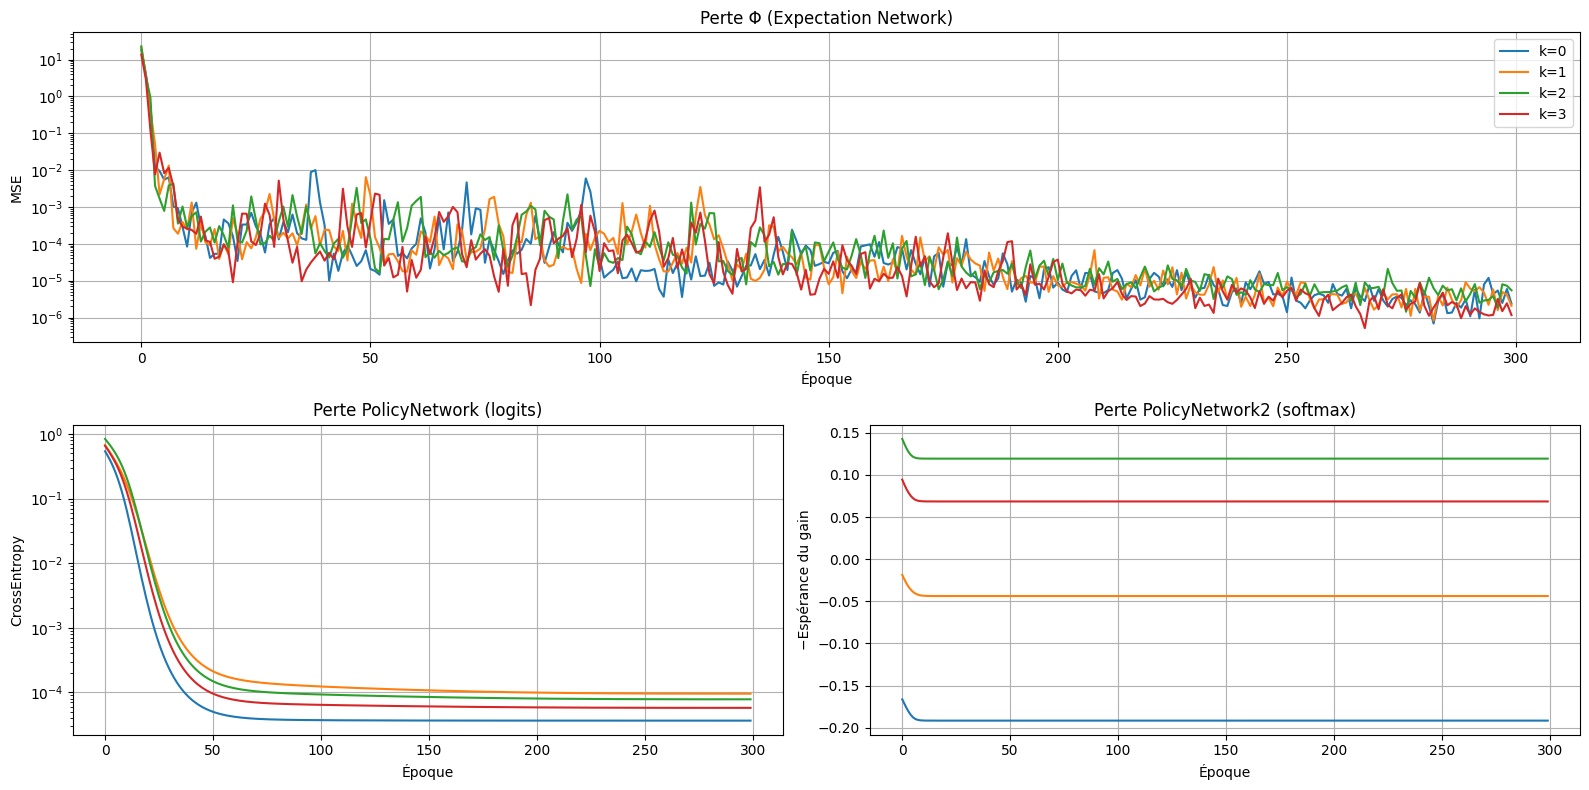

In [ ]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, :])
for k, losses in enumerate(phi_losses_all):
    ax1.plot(range(len(losses)), losses, label=f"k={k}")
ax1.set_title("Perte Φ (Expectation Network)")
ax1.set_xlabel("Époque")
ax1.set_ylabel("MSE")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend()

ax2 = fig.add_subplot(gs[1, 0])
for k, losses in enumerate(pi_classif_losses_all):
    ax2.plot(range(len(losses)), losses, label=f"k={k}")
ax2.set_title("Perte PolicyNetwork (logits)")
ax2.set_xlabel("Époque")
ax2.set_ylabel("CrossEntropy")
ax2.set_yscale("log")
ax2.grid(True)

ax3 = fig.add_subplot(gs[1, 1])
for k, losses in enumerate(pi_softmax_losses_all):
    ax3.plot(range(len(losses)), losses, label=f"k={k}")
ax3.set_title("Perte PolicyNetwork2 (softmax)")
ax3.set_xlabel("Époque")
ax3.set_ylabel("−Espérance du gain")
ax3.grid(True)

plt.tight_layout()
plt.savefig("losses_grid.png")
plt.show()


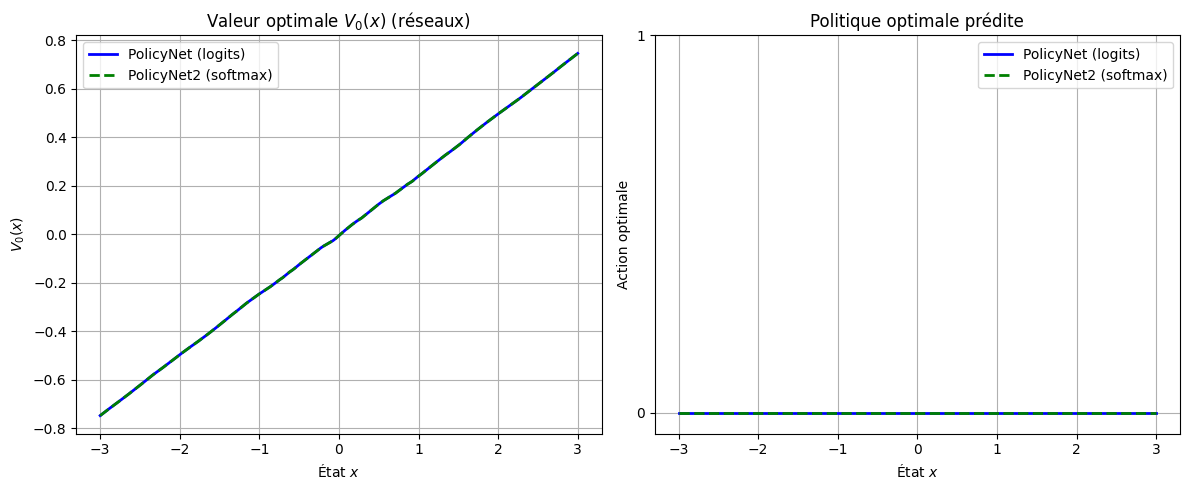

In [ ]:
# Grille d'états x
x_grid = torch.linspace(-3, 3, 200).unsqueeze(1).to(device)
x_grid_np = x_grid.cpu().numpy().flatten()

# Valeur optimale prédite avec PolicyNetwork (logits)
with torch.no_grad():
    V0_nn_classif = compute_value(phi_list[0], pi_classif_list[0], x_grid).cpu().numpy()

# Valeur optimale prédite avec PolicyNetwork2 (softmax, stochastique)
with torch.no_grad():
    V0_nn_soft = compute_value2(phi_list[0], pi_softmax_list[0], x_grid).cpu().numpy()

# Politique optimale prédite (PolicyNetwork : logits)
with torch.no_grad():
    logits_classif = pi_classif_list[0](x_grid)
    pi0_classif_det = torch.argmax(logits_classif, dim=1).cpu().numpy()

# Politique optimale prédite (PolicyNetwork2 : softmax)
with torch.no_grad():
    probas = pi_softmax_list[0](x_grid)
    pi0_soft_det = torch.argmax(probas, dim=1).cpu().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Valeur optimale
plt.subplot(1, 2, 1)
plt.plot(x_grid_np, V0_nn_classif.flatten(), 'b-', label='PolicyNet (logits)', linewidth=2)
plt.plot(x_grid_np, V0_nn_soft.flatten(), 'g--', label='PolicyNet2 (softmax)', linewidth=2)
plt.title('Valeur optimale $V_0(x)$ (réseaux)')
plt.xlabel('État $x$')
plt.ylabel('$V_0(x)$')
plt.legend()
plt.grid(True)

# Politique optimale
plt.subplot(1, 2, 2)
plt.plot(x_grid_np, pi0_classif_det, 'b-', label='PolicyNet (logits)', linewidth=2)
plt.plot(x_grid_np, pi0_soft_det, 'g--', label='PolicyNet2 (softmax)', linewidth=2)
plt.title('Politique optimale prédite')
plt.xlabel('État $x$')
plt.ylabel('Action optimale')
plt.yticks([0, 1])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Exemple 2 — Cas non linéaire sans solution explicite

Dans ce second test, on considère un problème plus complexe :
- la dynamique dépend du régime actif ;
- les fonctions de coût sont non linéaires ;
- la solution analytique est inconnue.

L’objectif est de comparer la solution obtenue par apprentissage profond à celle calculée via une méthode par différences finies.


In [ ]:
# Paramètres du problème de contrôle optimal
T = 1.0          # horizon temporel
N = 4           # nombre de pas de temps
h = T / N        # pas de discrétisation
A = [0.0, 1.0]   # ensemble des actions possibles
c = 0.05         # coût de switching
sigma = 0.1      # volatilité du bruit brownien


# Paramètres d'apprentissage
M = 1000         # nombre d'états simulés à chaque pas de temps
L = 1000          # nombre de trajectoires Monte Carlo par état
E_phi = 800      # nombre d'épochs
E_p = 800
alpha_phi = 1e-3
alpha_p = 5e-3
BATCH_SIZE = 128
CHUNK_GPU = 4096

# Fonctions du problème non triviales
def drift(x, a):
    """Fonction de dérive b(x,a)"""
    return a * x

def diffusion(x, a):
    """Fonction de diffusion σ(x,a)"""
    return sigma * (1 + 0.1 * a * x**2)

def running_cost_func(x, a):
    """Fonction de coût courant f(x,a)"""
    return -0.5 * x**2 * (1 + 0.2 * a)

def terminal_cost_func(x):
    """Fonction de coût terminal g(x)"""
    return np.where(x > 0, x**2, -0.5 * x**2)

# Fonctions adaptées pour PyTorch
@torch.no_grad()
def terminal_payoff(x):
    return torch.where(x > 0, x**2, -0.5 * x**2)

@torch.no_grad()
def running_payoff(x, a):
    return -0.5 * x**2 * (1 + 0.2 * a)


@torch.no_grad()
def brownian_step(x, a, dt):
    b = a * x
    sig = sigma * (1 + 0.1 * a * x**2)
    dW = torch.randn_like(x) * math.sqrt(dt)
    return x + b * dt + sig * dW

### Méthode de résolution par différences finies

Pour comparer les résultats obtenus par apprentissage profond, on implémente ici une méthode classique de résolution de l’équation de Bellman par **différences finies**.

Cette approche repose sur :
- une discrétisation spatiale régulière de l’état $x$,
- une propagation backward sur la grille temporelle,
- et une maximisation explicite du gain à chaque étape.

Elle sert de référence pour évaluer la précision de l’approximation neuronale dans l'exemple suivant.

In [ ]:
class FiniteDifferenceSolver:
    def __init__(self, x_min=-3.0, x_max=3.0, nx=1001, T=T, nt=N):
        self.x_min, self.x_max = x_min, x_max
        self.nx = nx
        self.dx = (x_max - x_min) / (nx - 1)
        self.x_grid = np.linspace(x_min, x_max, nx)

        self.T = T
        self.nt = nt
        self.dt = T / nt

        self.setup_matrices()

    def setup_matrices(self):
        """Construction avec Neumann homogène """
        nx = self.nx
        dx = self.dx

        self.D1 = diags([-1, 0, 1], [-1, 0, 1], shape=(nx, nx)).tolil() / (2 * dx)
        self.D1[0, 0:2] = np.array([-1, 1]) / dx
        self.D1[-1, -2:] = np.array([-1, 1]) / dx
        self.D1 = self.D1.tocsc()

        self.D2 = diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)).tolil() / dx**2
        self.D2[0, 0:3] = np.array([1, -2, 1]) / dx**2
        self.D2[-1, -3:] = np.array([1, -2, 1]) / dx**2
        self.D2 = self.D2.tocsc()



    def solve(self):
        v0 = np.zeros((self.nx, len(A)))
        v1 = np.zeros((self.nx, len(A)))

        for i, a in enumerate(A):
            v1[:, i] = terminal_cost_func(self.x_grid)

        solutions = [v1.copy()]

        for k in range(self.nt - 1, -1, -1):
            v0 = self.backward_step(v1)
            solutions.insert(0, v0.copy())
            v1 = v0.copy()

        return solutions

    def backward_step(self, v_next):
        nx = self.nx
        dt = self.dt
        v_candidate = np.zeros((nx, len(A)))  # Valeur de rester dans chaque régime

        # Étape 1 : résolution implicite pour chaque régime i
        for i, regime_i in enumerate(A):
            b_vals = drift(self.x_grid, regime_i)
            sigma2_vals = diffusion(self.x_grid, regime_i)**2
            f_vals = running_cost_func(self.x_grid, regime_i)

            # Opérateur différentiel
            L_i = diags(b_vals) @ self.D1 + 0.5 * diags(sigma2_vals) @ self.D2

            A_matrix = eye(nx, format='csc') - dt * L_i
            rhs = v_next[:, i] + dt * f_vals

            # Résolution du système linéaire
            v_candidate[:, i] = spsolve(A_matrix.tocsr(), rhs)


        # Étape 2 : appliquer la condition de switching
        v_current = np.zeros_like(v_candidate)

        for i in range(len(A)):
            # Valeur si on switch vers j ≠ i
            switch_values = []
            for j in range(len(A)):
                if j != i:
                    switch_values.append(v_candidate[:, j] - c)
            switch_value = np.max(switch_values, axis=0)

            # Maximum entre rester (v_candidate[:, i]) et switcher
            v_current[:, i] = np.maximum(v_candidate[:, i], switch_value)

        return v_current

### Résolution, comparaison et visualisation

In [ ]:
# Résolution et comparaison
print("=== Solving with finite differences ===")
fd_solver = FiniteDifferenceSolver()
fd_solutions = fd_solver.solve()

print("\n=== Solving with neural networks ===")
phi_list2, pi_classif_list2, pi_softmax_list2, phi_losses_all2, pi_classif_losses_all2, pi_softmax_losses_all2 = solve_neural_networks()

=== Solving with finite differences ===

=== Solving with neural networks ===

── Time step k=3 ──
Generating data …
Training Φ …
    Epoch 0, Φ-loss=7.9431e+00, lr=1.00e-03
    Epoch 50, Φ-loss=3.9687e-03, lr=9.90e-04
    Epoch 100, Φ-loss=4.6871e-04, lr=9.61e-04
    Epoch 150, Φ-loss=8.7138e-04, lr=9.15e-04
    Epoch 200, Φ-loss=2.3253e-04, lr=8.52e-04
    Epoch 250, Φ-loss=1.2847e-04, lr=7.76e-04
    Epoch 300, Φ-loss=1.2883e-04, lr=6.90e-04
    Epoch 350, Φ-loss=2.9058e-04, lr=5.96e-04
    Epoch 400, Φ-loss=1.4094e-04, lr=4.98e-04
    Epoch 450, Φ-loss=8.4994e-05, lr=4.01e-04
    Epoch 500, Φ-loss=1.0832e-04, lr=3.07e-04
    Epoch 550, Φ-loss=6.9050e-05, lr=2.21e-04
    Epoch 600, Φ-loss=5.7299e-05, lr=1.45e-04
    Epoch 650, Φ-loss=7.1768e-05, lr=8.32e-05
    Epoch 700, Φ-loss=4.4156e-05, lr=3.73e-05
    Epoch 750, Φ-loss=3.5731e-05, lr=9.23e-06
    Epoch 799, Φ-loss=6.4835e-05, lr=0.00e+00
Training π (PolicyNetwork) …
    Epoch 0, π-classif-loss=7.0903e-01, acc=0.475, lr=5.00e-03

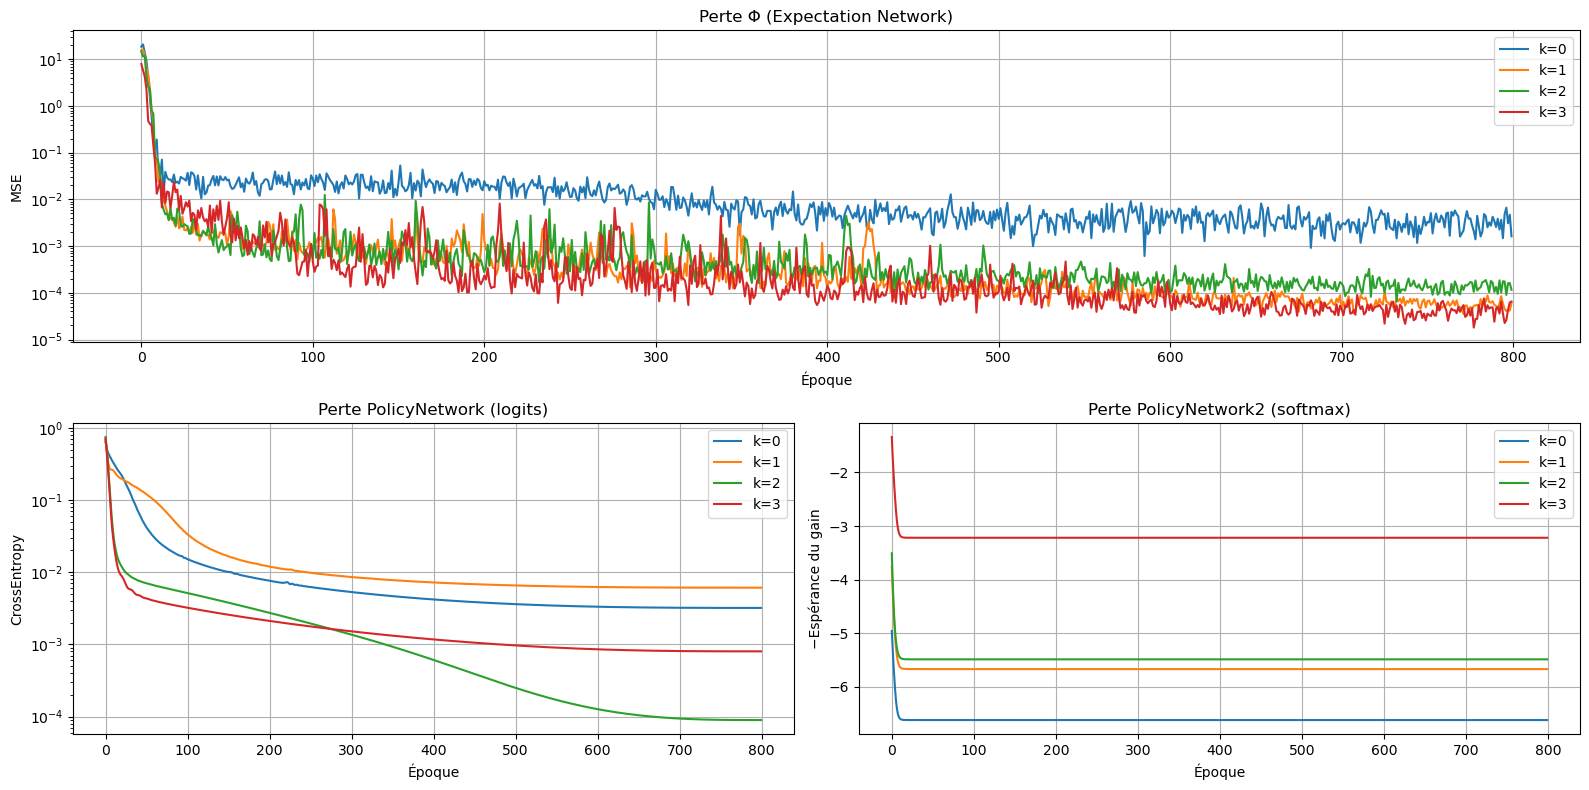

In [ ]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, :])
for k, losses in enumerate(phi_losses_all2):
    ax1.plot(range(len(losses)), losses, label=f"k={k}")
ax1.set_title("Perte Φ (Expectation Network)")
ax1.set_xlabel("Époque")
ax1.set_ylabel("MSE")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend()

ax2 = fig.add_subplot(gs[1, 0])
for k, losses in enumerate(pi_classif_losses_all2):
    ax2.plot(range(len(losses)), losses, label=f"k={k}")
ax2.set_title("Perte PolicyNetwork (logits)")
ax2.set_xlabel("Époque")
ax2.set_ylabel("CrossEntropy")
ax2.set_yscale("log")
ax2.grid(True)
ax2.legend()

ax3 = fig.add_subplot(gs[1, 1])
for k, losses in enumerate(pi_softmax_losses_all2):
    ax3.plot(range(len(losses)), losses, label=f"k={k}")
ax3.set_title("Perte PolicyNetwork2 (softmax)")
ax3.set_xlabel("Époque")
ax3.set_ylabel("−Espérance du gain")
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.savefig('losses_difficile4.png')
plt.show()

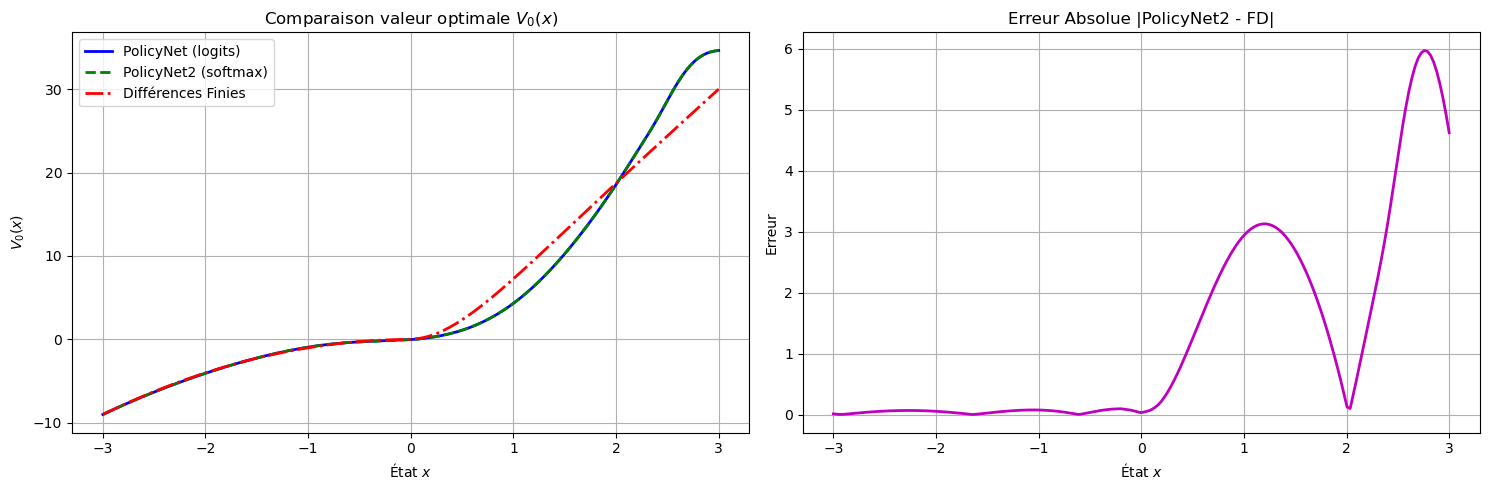

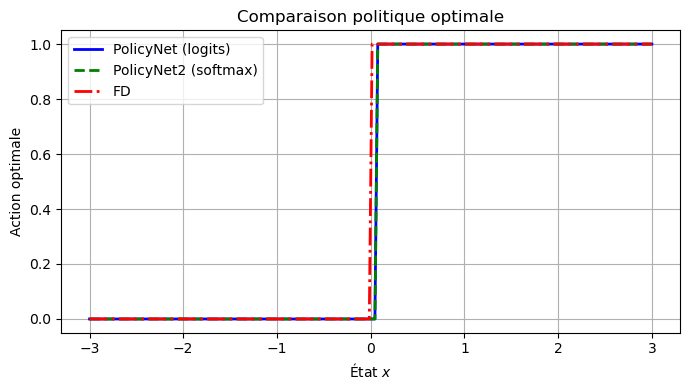

In [ ]:
# Visualisation et comparaison
x_grid = torch.linspace(-3, 3, 200).unsqueeze(1).to(device)
x_grid_np = x_grid.cpu().numpy().flatten()

# Valeur optimale avec PolicyNetwork (logits)
with torch.no_grad():
    V0_nn_classif = compute_value(phi_list2[0], pi_classif_list2[0], x_grid).cpu().numpy()

# Valeur optimale avec PolicyNetwork2 (softmax, stochastique)
with torch.no_grad():
    V0_nn_soft = compute_value2(phi_list2[0], pi_softmax_list2[0], x_grid).cpu().numpy()

# Valeur optimale avec différences finies
V0_fd_regime0 = np.interp(x_grid_np, fd_solver.x_grid, fd_solutions[0][:, 0])
V0_fd_regime1 = np.interp(x_grid_np, fd_solver.x_grid, fd_solutions[0][:, 1])
V0_fd = np.maximum(V0_fd_regime0, V0_fd_regime1)

# Politique optimale prédite (PolicyNetwork : logits)
with torch.no_grad():
    logits_classif = pi_classif_list2[0](x_grid)
    pi0_classif_det = torch.argmax(logits_classif, dim=1).cpu().numpy()

# Politique optimale prédite (PolicyNetwork2 : softmax)
with torch.no_grad():
    probas = pi_softmax_list2[0](x_grid)
    pi0_soft_det = torch.argmax(probas, dim=1).cpu().numpy()

# Politique optimale (différences finies)
policy_fd = (V0_fd_regime1 > V0_fd_regime0).astype(float)

plt.figure(figsize=(15, 5))

# Valeur optimale
plt.subplot(1, 2, 1)
plt.plot(x_grid_np, V0_nn_classif.flatten(), 'b-', label='PolicyNet (logits)', linewidth=2)
plt.plot(x_grid_np, V0_nn_soft.flatten(), 'g--', label='PolicyNet2 (softmax)', linewidth=2)
plt.plot(x_grid_np, V0_fd, 'r-.', label='Différences Finies', linewidth=2)
plt.title('Comparaison valeur optimale $V_0(x)$')
plt.xlabel('État $x$')
plt.ylabel('$V_0(x)$')
plt.legend()
plt.grid(True)

# Erreur absolue
plt.subplot(1, 2, 2)
error = np.abs(V0_nn_soft.flatten() - V0_fd)
plt.plot(x_grid_np, error, 'm-', linewidth=2)
plt.title('Erreur Absolue |PolicyNet2 - FD|')
plt.xlabel('État $x$')
plt.ylabel('Erreur')
plt.grid(True)

plt.tight_layout()
plt.savefig('valeur_optimale_difficile4.png')
plt.show()

# Politique optimale
plt.figure(figsize=(7, 4))
plt.plot(x_grid_np, pi0_classif_det, 'b-', label='PolicyNet (logits)', linewidth=2)
plt.plot(x_grid_np, pi0_soft_det, 'g--', label='PolicyNet2 (softmax)', linewidth=2)
plt.plot(x_grid_np, policy_fd, 'r-.', label='FD', linewidth=2)
plt.title('Comparaison politique optimale')
plt.xlabel('État $x$')
plt.ylabel('Action optimale')
plt.legend()
plt.grid(True)
plt.savefig('politique_optimale_difficile4.png')
plt.tight_layout()
plt.show()